In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets
# !pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import os
import torch
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.optim import AdamW
from datasets import Dataset
from accelerate import Accelerator
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_recall_fscore_support, accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, EsmForSequenceClassification
from transformers import AutoConfig
from transformers import TrainingArguments, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [ ]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
device = torch.device('cuda')
# torch.cuda.is_available()

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Nov 29 15:33:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0              46W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
ds_arg = pd.read_csv('/content/drive/MyDrive/PUBH 8885 CB/long_read_arg_dataset.csv')
ds_arg.head()

,id,db,type,sequence,dna_seq
0,B9J113,UNIPROT,beta_lactam,MKHKNQATHKEFSQLEKKFDARLGLYAIDTGTNQTIAYRPNERFAF...,GTGAAACATAAAAATCAGGCGACGCATAAAGAGTTCTCTCAACTTG...
1,A0A147H3Q5,UNIPROT,bacitracin,MDLWSALQALILGIVEGITEFLPISSTGHQIIVADLIGFGGERAIA...,ATGAATTGGTGGGAGCTGTTTGTTGCTTTAATTCTTGGTCTAGTGG...
2,A0A133N6E2,UNIPROT,bacitracin,MGIDFLFILKALIIAVVEGLTEFVPVSSTGHMILVGDLIHFNTQSG...,ATGGGAATTGATTTTTTATTCATACTTAAGGCCTTAATAATCGCAG...
3,A0A024P8A8,UNIPROT,beta_lactam,MKKIYESKFSMRQVKMFMSLLVLITLAACFDSTNSTNVSSKEGNEV...,TCACTTTAGGGCATTAAGAGCGACCTTGGCAGCCTGCGCAATTAGC...
4,A0A0Q3WM94,UNIPROT,chloramphenicol,MFKQIDENYPRKEHFHHYMTVTRCTYSLVIDLDITKLYAILKEKRL...,ATGAATGCAATTATGTTAGTTATCATTCTTGCACTAGTTGAAGGTA...


In [ ]:
# number of unique drug resistance type
print("# Unique Resistance Types:", len(set(ds_arg['type'])),"\n\nUnique Resistance Types:", ds_arg['type'].unique())

# Unique Resistance Types: 26 

Unique Resistance Types: ['beta_lactam' 'bacitracin' 'chloramphenicol' 'aminoglycoside'
 'macrolide-lincosamide-streptogramin' 'multidrug' 'polymyxin'
 'fosfomycin' 'sulfonamide' 'glycopeptide' 'mupirocin' 'trimethoprim'
 'quinolone' 'fosmidomycin' 'tetracycline' 'rifampin' 'peptide'
 'kasugamycin' 'qa_compound' 'fusidic_acid' 'tunicamycin' 'tetracenomycin'
 'streptothricin' 'thiostrepton' 'aminocoumarin' 'non_resistant']


In [ ]:
max_length = ds_arg['dna_seq'].str.len().max()
max_length

3594

In [ ]:
ds_arg.columns

Index(['id', 'db', 'type', 'sequence', 'dna_seq'], dtype='object')

In [ ]:
type_counts = ds_arg['type'].value_counts()
type_counts

,count
type,
beta_lactam,4754
bacitracin,3932
macrolide-lincosamide-streptogramin,982
polymyxin,859
aminoglycoside,767
non_resistant,447
chloramphenicol,436
multidrug,403
fosfomycin,240


In [ ]:
# Filter to keep only types with more than one occurrence
ds_arg = ds_arg[ds_arg['type'].isin(type_counts[type_counts > 1].index)]

In [ ]:
# Create label encoder for drug resistance types
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(ds_arg['type'])

In [ ]:
labels

array([ 2,  1,  1, ..., 12, 12, 12])

In [ ]:
# Split data
sequences = ds_arg['dna_seq'].values

# Get class counts
class_counts = np.bincount(labels)

# Find classes with only one sample
single_sample_classes = np.where(class_counts == 1)[0]

In [ ]:
#If there are classes with only one sample remove them from the dataset
if len(single_sample_classes) > 0:
  print(f"Removing classes with only one sample: {single_sample_classes}")
  # Create a mask to select samples not belonging to single-sample classes
  mask = ~np.isin(labels, single_sample_classes)
  sequences = sequences[mask]
  labels = labels[mask]

In [ ]:
print("number of classes:",len(set(labels)))

number of classes: 23


In [ ]:
dataset = pd.DataFrame({
    'sequence': sequences,
    'label': labels
})
print(dataset)

                                                sequence  label
0      GTGAAACATAAAAATCAGGCGACGCATAAAGAGTTCTCTCAACTTG...      2
1      ATGAATTGGTGGGAGCTGTTTGTTGCTTTAATTCTTGGTCTAGTGG...      1
2      ATGGGAATTGATTTTTTATTCATACTTAAGGCCTTAATAATCGCAG...      1
3      TCACTTTAGGGCATTAAGAGCGACCTTGGCAGCCTGCGCAATTAGC...      2
4      ATGAATGCAATTATGTTAGTTATCATTCTTGCACTAGTTGAAGGTA...      3
...                                                  ...    ...
13354  TAACGAATTTATGATGGAATTCCATCATCGACATAGTGCTTGTCAA...     12
13355  TAACGAATTTATGATGGAATTCCATCATCGACATAGTGCTTGTCAA...     12
13356  ATCGAATTGATGATGGAATTCCATCATCAATAAATTGCTTGTCAAA...     12
13357  ATCGAATTGATGATGGAATTCCATCATCAATAAATTGCTTGTCAAA...     12
13358  ATCGAATTGATGATGGAATTCCATCATCAATAAATTGCTTGTCAAA...     12

[13359 rows x 2 columns]


In [ ]:
# Create Train Test split
train_sequences, test_sequences, train_labels, test_labels = train_test_split(dataset['sequence'], dataset['label'], test_size=0.08, random_state=42,stratify=labels)

train_sequences, validation_sequences, train_labels, validation_labels = train_test_split(train_sequences, train_labels, test_size=0.08, random_state=42)

print("Train Size:",len(train_sequences), "\nValidation Size:", len(validation_sequences), "\nTest Size:", len(test_sequences))

Train Size: 11306 
Validation Size: 984 
Test Size: 1069


In [ ]:
model_name = "InstaDeepAI/nucleotide-transformer-v2-100m-multi-species"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

In [ ]:
# Sequence splitting function
def split_sequence(sequence, max_len=1024, overlap=512):
    chunks = []
    for i in range(0, len(sequence), max_len - overlap):
        chunk = sequence[i:i + max_len]
        if len(chunk) > 0:
            chunks.append(chunk)
    return chunks

In [ ]:
# Preprocess data (split and label encoding)
def preprocess_data(sequences, labels, max_len=1024, overlap=512):
    split_sequences = []
    split_labels = []
    for seq, label in zip(sequences, labels):
        chunks = split_sequence(seq, max_len=max_len, overlap=overlap)
        split_sequences.extend(chunks)
        split_labels.extend([label] * len(chunks))
    return split_sequences, split_labels

In [ ]:
# Tokenization and Dataset class
class ArgDataset(Dataset):
    def __init__(self, sequences, labels, tokenizer, max_len=1024):
        self.encodings = tokenizer(
            sequences,
            truncation=True,
            padding=True,
            max_length=max_len,
            return_tensors="pt",
        )
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

In [ ]:
# Split and preprocess the sequences
train_sequences, train_labels = preprocess_data(train_sequences, train_labels)
validation_sequences, validation_labels = preprocess_data(validation_sequences, validation_labels)
test_sequences, test_labels = preprocess_data(test_sequences, test_labels)

In [ ]:
# Create datasets
train_dataset = ArgDataset(train_sequences, train_labels, tokenizer)
validation_dataset = ArgDataset(validation_sequences, validation_labels, tokenizer)
test_dataset = ArgDataset(test_sequences, test_labels, tokenizer)

In [ ]:
len(train_dataset.__getitem__(0)['input_ids'])

1024

In [ ]:
print(len(train_sequences), len(train_labels))
print(len(validation_sequences), len(validation_labels))
print(len(test_sequences), len(test_labels))

26204 26204
2296 2296
2512 2512


In [ ]:
n_labels = len(set(dataset['label']))
print(set(dataset['label']))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}


In [ ]:
config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
print(config)

config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

esm_config.py:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-100m-multi-species:
- esm_config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


EsmConfig {
  "_name_or_path": "InstaDeepAI/nucleotide-transformer-v2-100m-multi-species",
  "add_bias_fnn": false,
  "architectures": [
    "EsmForMaskedLM",
    "EsmForTokenClassification",
    "EsmForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "auto_map": {
    "AutoConfig": "InstaDeepAI/nucleotide-transformer-v2-100m-multi-species--esm_config.EsmConfig",
    "AutoModelForMaskedLM": "InstaDeepAI/nucleotide-transformer-v2-100m-multi-species--modeling_esm.EsmForMaskedLM",
    "AutoModelForSequenceClassification": "InstaDeepAI/nucleotide-transformer-v2-100m-multi-species--modeling_esm.EsmForSequenceClassification",
    "AutoModelForTokenClassification": "InstaDeepAI/nucleotide-transformer-v2-100m-multi-species--modeling_esm.EsmForTokenClassification"
  },
  "emb_layer_norm_before": false,
  "esmfold_config": null,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "is_folding_model": false,
  "layer_

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(set(labels)),
    trust_remote_code=True,
    ignore_mismatched_sizes=True
)

modeling_esm.py:   0%|          | 0.00/58.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-100m-multi-species:
- modeling_esm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/392M [00:00<?, ?B/s]

Some weights of the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-100m-multi-species were not used when initializing EsmForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-100m-multi-species and are newly initialized: ['classifier.dense.bias', 

In [ ]:
# Define the metric for the evaluation using the f1 score
# def compute_metrics(eval_pred):
#     """Computes F1 score for multi-class classification"""
#     predictions = np.argmax(eval_pred.predictions, axis=-1)
#     references = eval_pred.label_ids

#     # Compute weighted F1 score to account for class imbalance
#     f1 = f1_score(references, predictions, average='weighted')

#     macro_f1 = f1_score(references, predictions, average='macro')
#     micro_f1 = f1_score(references, predictions, average='micro')

#     return {
#         'weighted_f1_score': f1,
#         'macro_f1_score': macro_f1,
#         'micro_f1_score': micro_f1
#     }
def compute_metrics(eval_pred):
    """Computes F1 score for multi-class classification"""
    labels = eval_pred.label_ids
    predictions = np.argmax(eval_pred.predictions, axis=-1)

#    precision, recall, f1, support = precision_recall_fscore_support(labels, predictions, average=None, labels=range(n_labels))

    micro_precision, micro_recall, micro_f1, micro_support = precision_recall_fscore_support(labels, predictions, average='micro')

    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')

    weighted_precision, weighted_recall, weighted_f1, weighted_support = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        # 'precision': precision,
        # 'recall': recall,
        # 'f1': f1,
        'micro_precision': micro_precision,
        'macro_precision': macro_precision,
        'weighted_precision': weighted_precision,
        'micro_recall': micro_recall,
        'macro_recall': macro_recall,
        'weighted_recall': weighted_recall,
        'micro_f1': micro_f1,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1
    }

In [ ]:
training_args = TrainingArguments(
    "/content/drive/MyDrive/PUBH 8885 CB/nuc_arg_long_readv4",
    remove_unused_columns=False,
    report_to="none",
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=2.5e-5,
    lr_scheduler_type="cosine",
    warmup_steps=500,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=8,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_weighted_f1",
    fp16=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-33-ba2400f7b8a9>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Train the model
trainer.train()

Step,Training Loss,Validation Loss,Micro Precision,Macro Precision,Weighted Precision,Micro Recall,Macro Recall,Weighted Recall,Micro F1,Macro F1,Weighted F1
100,2.872200,2.381986,0.484756,0.065909,0.300099,0.484756,0.102633,0.484756,0.484756,0.079161,0.365809
200,1.946700,1.618881,0.603223,0.172963,0.510242,0.603223,0.145199,0.603223,0.603223,0.123528,0.502828
300,1.501900,1.327062,0.687282,0.163916,0.582133,0.687282,0.206067,0.687282,0.687282,0.180952,0.626703
400,1.260200,1.157090,0.715157,0.250395,0.652352,0.715157,0.260231,0.715157,0.715157,0.247962,0.674291
500,1.011600,0.875945,0.801829,0.427055,0.778678,0.801829,0.405225,0.801829,0.801829,0.406623,0.785608
600,0.853900,0.763539,0.834059,0.498583,0.826341,0.834059,0.492674,0.834059,0.834059,0.472495,0.826035
700,0.739800,0.682771,0.846690,0.595920,0.836882,0.846690,0.516030,0.846690,0.846690,0.515649,0.835931
800,0.672800,0.612245,0.852787,0.670080,0.860259,0.852787,0.553745,0.852787,0.852787,0.560969,0.846599
900,0.559300,0.603323,0.862805,0.645809,0.862071,0.862805,0.622386,0.862805,0.862805,0.626963,0.860494
1000,0.549200,0.578538,0.861063,0.716119,0.875058,0.861063,0.656159,0.861063,0.861063,0.656817,0.863537


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

TrainOutput(global_step=2045, training_loss=0.7925261812280034, metrics={'train_runtime': 6769.67, 'train_samples_per_second': 19.354, 'train_steps_per_second': 0.302, 'total_flos': 7.448570060419891e+16, 'train_loss': 0.7925261812280034, 'epoch': 4.993894993894994})

In [ ]:
print(trainer.state.log_history)

[{'loss': 2.8722, 'grad_norm': 25.231292724609375, 'learning_rate': 5e-06, 'epoch': 0.2442002442002442, 'step': 100}, {'eval_loss': 2.381986141204834, 'eval_micro_precision': 0.4847560975609756, 'eval_macro_precision': 0.06590895945398809, 'eval_weighted_precision': 0.3000991244760369, 'eval_micro_recall': 0.4847560975609756, 'eval_macro_recall': 0.10263326510757667, 'eval_weighted_recall': 0.4847560975609756, 'eval_micro_f1': 0.4847560975609756, 'eval_macro_f1': 0.07916135790210403, 'eval_weighted_f1': 0.3658094645034367, 'eval_runtime': 27.9503, 'eval_samples_per_second': 82.146, 'eval_steps_per_second': 1.288, 'epoch': 0.2442002442002442, 'step': 100}, {'loss': 1.9467, 'grad_norm': 74.01921844482422, 'learning_rate': 9.950000000000001e-06, 'epoch': 0.4884004884004884, 'step': 200}, {'eval_loss': 1.6188805103302002, 'eval_micro_precision': 0.6032229965156795, 'eval_macro_precision': 0.1729632869793354, 'eval_weighted_precision': 0.5102415198384107, 'eval_micro_recall': 0.603222996515

In [ ]:
curve_evaluation_f1_score = [
    [a['step'], a['eval_weighted_f1']]
    for a in trainer.state.log_history
    if 'eval_weighted_f1' in a.keys()
]

In [ ]:
curve_evaluation_f1_score

[[100, 0.3658094645034367],
 [200, 0.502828345764972],
 [300, 0.6267031640391093],
 [400, 0.6742913163869271],
 [500, 0.7856079074786287],
 [600, 0.8260353217142836],
 [700, 0.8359309638776365],
 [800, 0.8465989784626531],
 [900, 0.8604939320250599],
 [1000, 0.8635374104852748],
 [1100, 0.8844974105345418],
 [1200, 0.8867237445831763],
 [1300, 0.8881457405419927],
 [1400, 0.8908187701448725],
 [1500, 0.8924948901640382],
 [1600, 0.8920440495537268],
 [1700, 0.8925287132268782],
 [1800, 0.8922264575847318],
 [1900, 0.8930435871808095],
 [2000, 0.8913514985216604]]

In [ ]:
eval_f1_score = [c[1] for c in curve_evaluation_f1_score]
steps = [c[0] for c in curve_evaluation_f1_score]

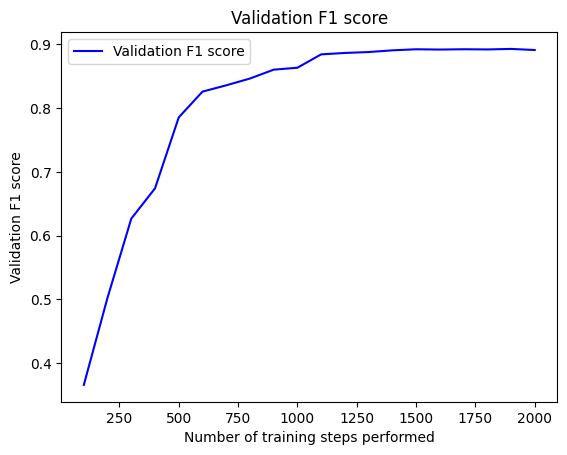

In [ ]:
plt.plot(steps, eval_f1_score, 'b', label='Validation F1 score')
plt.title('Validation F1 score')
plt.xlabel('Number of training steps performed')
plt.ylabel('Validation F1 score')
plt.legend()
plt.show()

In [ ]:
# trainer.log_metrics("train", metrics)
# trainer.save_metrics("train", metrics)
trainer.save_state()
trainer.save_model("/content/drive/MyDrive/PUBH 8885 CB/nuc_arg_long_readv4-sm")

In [ ]:
model.save_pretrained('/content/drive/MyDrive/PUBH 8885 CB/nuc_arg_long_readv4-m')
tokenizer.save_pretrained('/content/drive/MyDrive/PUBH 8885 CB/nuc_arg_long_readv4-t')

('/content/drive/MyDrive/PUBH 8885 CB/nuc_arg_long_readv4-t/tokenizer_config.json',
 '/content/drive/MyDrive/PUBH 8885 CB/nuc_arg_long_readv4-t/special_tokens_map.json',
 '/content/drive/MyDrive/PUBH 8885 CB/nuc_arg_long_readv4-t/vocab.txt',
 '/content/drive/MyDrive/PUBH 8885 CB/nuc_arg_long_readv4-t/added_tokens.json')

## Long read Test data

In [ ]:
test_results = trainer.predict(test_dataset)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print("Test Metrics:", test_results.metrics)

Test Metrics: {'test_loss': 0.541509747505188, 'test_micro_precision': 0.8817675159235668, 'test_macro_precision': 0.7475472859704777, 'test_weighted_precision': 0.8822449367989604, 'test_micro_recall': 0.8817675159235668, 'test_macro_recall': 0.7350095786113764, 'test_weighted_recall': 0.8817675159235668, 'test_micro_f1': 0.8817675159235668, 'test_macro_f1': 0.7362441952492014, 'test_weighted_f1': 0.8809847482222547, 'test_runtime': 4.8836, 'test_samples_per_second': 514.376, 'test_steps_per_second': 8.191}


In [ ]:
predicted_classes = np.argmax(test_results.predictions, axis=1)

In [ ]:
# Compare predictions with true labels
true_labels = test_results.label_ids
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_classes))

              precision    recall  f1-score   support

           0       0.83      0.72      0.77       109
           1       0.91      0.90      0.91       647
           2       0.93      0.92      0.92       897
           3       0.76      0.71      0.73        68
           4       0.94      0.60      0.73        25
           7       0.67      0.76      0.71        29
           9       0.79      0.86      0.82       257
          10       0.84      0.84      0.84       122
          12       0.89      1.00      0.94        72
          13       0.00      0.00      0.00         1
          14       0.85      0.85      0.85       211
          16       1.00      0.86      0.92        14
          17       0.80      1.00      0.89         8
          18       0.00      0.00      0.00         2
          20       0.75      0.91      0.82        44
          21       1.00      0.83      0.91         6

    accuracy                           0.88      2512
   macro avg       0.75   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Short read test data

In [ ]:
short_reads = pd.read_csv('/content/drive/MyDrive/PUBH 8885 CB/short_reads_with_type.csv')
short_reads.head()

,id,type,Sequence
0,B9J113,beta_lactam,GTGAAACATAAAAATCAGGCGACGCATAAAGAGTTCTCTCAACTTG...
1,B9J113,beta_lactam,AAACAATCGCTTATCGACCTAACGAAAGGTTTGCCTTTGCATCAAC...
2,B9J113,beta_lactam,AGATGAAGTTATTACTTATACGAAAGAAGACTTAGTGGATTATTCA...
3,B9J113,beta_lactam,GCTGCTGTTCGTTACAGTGATAATACTGCAGGGAACATTTTATTTC...
4,B9J113,beta_lactam,GGGTTACTATGTCTGATCGCTTTGAAACAGAGTTAAACGAAGCTAT...


In [ ]:
# number of unique drug resistance type
print("# Unique Resistance Types:", len(set(short_reads['type'])),"\n\nUnique Resistance Types:", short_reads['type'].unique())

# Unique Resistance Types: 15 

Unique Resistance Types: ['beta_lactam' 'bacitracin' 'chloramphenicol' 'aminoglycoside'
 'macrolide-lincosamide-streptogramin' 'multidrug' 'polymyxin'
 'fosfomycin' 'sulfonamide' 'glycopeptide' 'mupirocin' 'trimethoprim'
 'quinolone' 'fosmidomycin' 'tetracycline']


In [ ]:
short_reads.columns

Index(['id', 'type', 'Sequence'], dtype='object')

In [ ]:
# Split data
ss_sequences = short_reads['Sequence'].values

In [ ]:
# Create label encoder for drug resistance types
ss_labels = label_encoder.fit_transform(short_reads['type'])

In [ ]:
ss_dataset = pd.DataFrame({
    'sequence': ss_sequences,
    'label': ss_labels
})
print(ss_dataset)

                                                sequence  label
0      GTGAAACATAAAAATCAGGCGACGCATAAAGAGTTCTCTCAACTTG...      2
1      AAACAATCGCTTATCGACCTAACGAAAGGTTTGCCTTTGCATCAAC...      2
2      AGATGAAGTTATTACTTATACGAAAGAAGACTTAGTGGATTATTCA...      2
3      GCTGCTGTTCGTTACAGTGATAATACTGCAGGGAACATTTTATTTC...      2
4      GGGTTACTATGTCTGATCGCTTTGAAACAGAGTTAAACGAAGCTAT...      2
...                                                  ...    ...
96140  GTGGCTGAACTCCATTACTGTCAGGGTGAAAGAAGGATTTGACAGC...      7
96141  GATTTCTTTACCTGGAACATGGACGGCGTCTTGAAAACCGTTGAAA...      7
96142  TGGTGGGCGGTATTGGTGTAATGAATATTATGCTGGTGTCAGTGAC...      7
96143  TGTTTTGCAACAGTTCCTGATCGAAGCCGTGCTGGTTTGCCTGGTC...      7
96144  TTCTTACCCGGCTGGGAGATTGGTTTTTCACCGTTGGCGCTGCTGC...      7

[96145 rows x 2 columns]


In [ ]:
# Create Train Test split
ss_train_sequences, ss_test_sequences, ss_train_labels, ss_test_labels = train_test_split(ss_dataset['sequence'], ss_dataset['label'], test_size=0.1, random_state=42)

In [ ]:
ss_test_sequences, ss_test_labels = preprocess_data(ss_test_sequences, ss_test_labels)

In [ ]:
ss_test_dataset = ArgDataset(ss_test_sequences, ss_test_labels, tokenizer)

In [ ]:
ss_test_results = trainer.predict(ss_test_dataset)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [ ]:
print("Short Read Test Metrics:", ss_test_results.metrics)

Short Read Test Metrics: {'test_loss': 2.7949256896972656, 'test_micro_precision': 0.2696827873114925, 'test_macro_precision': 0.11209192919065418, 'test_weighted_precision': 0.4477075186930509, 'test_micro_recall': 0.2696827873114925, 'test_macro_recall': 0.10697475401837209, 'test_weighted_recall': 0.2696827873114925, 'test_micro_f1': 0.2696827873114925, 'test_macro_f1': 0.07402554149271498, 'test_weighted_f1': 0.2464006343141424, 'test_runtime': 9.0124, 'test_samples_per_second': 1066.865, 'test_steps_per_second': 16.755}


In [ ]:
ss_predicted_classes = np.argmax(ss_test_results.predictions, axis=1)

In [ ]:
# Compare predictions with true labels
ss_true_labels = ss_test_results.label_ids
print(classification_report(ss_true_labels, ss_predicted_classes))

              precision    recall  f1-score   support

           0       0.13      0.10      0.11       373
           1       0.81      0.07      0.13      3203
           2       0.43      0.63      0.51      3108
           3       0.06      0.42      0.11       218
           4       0.00      0.00      0.00       111
           6       0.00      0.00      0.00        10
           7       0.12      0.10      0.11      1309
           8       0.00      0.00      0.00       162
           9       0.00      0.14      0.00         7
          10       0.13      0.15      0.14      1108
          11       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         0

    accuracy                           0.27      9615
   macro avg       0.11      0.11      0.07      9615
weighted avg       0.45   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

## Test on sample input

In [ ]:
test_seq = 'TTTTTAATAGTTATCTATTATTTAACGGGAGGAAATAATTCTATGAGTCGCTTTTTTAAATTTGGAAAGTTACACGTTACTAAAGGGAATGGAGATAAATTATTAGATATACTACTGACAGCTTCCAAGAAGCTAAAGAGGTCCCTAGCGCCTACGGGGAATTTGTATCGATAAGGGGTACAAATTCCCACTAAGCGCTCGGGACCCCTTGTAGGAAAATGTCCTAAGTGTGGCAACAATATTGTATTAAAAAAATCGTTTTATGGTTGTTCAAATGGTTCTGTTGCAAAGTTTTAAATAAAGAATAAAATCCCTTACGGTATCTATGATTTAAGCTGGGATTCCCAATAATACCTTGATTTCAGTACAGACCGAAAACCCGAAGAGAGTGCCTTCTTTTCGGGTTTTCTTATATAATCCTCGAATGGCTTCCATGCCTTTAATCGTGGTAGAGGCAGTGCGTAAACTTCGATAGAATTTATTGCGTCTCTTTACTGGACGATGGTCTTGTTCAATCAAATTATTCAGGTATTTAATGGTACGATGTTCTGTCCCCTTGATAAAAGCCGTATTCTTTTAGTTTCTTAAAGGCACTTGAATAGAGGGGGCTTTATCTGTGACTACAACCTTCGGTTCATCAAACTGCTTCACTAACCGCTTAAGAAAAGCATAGGCTGCTTGTGGGGGTACCGTCAGGAAAATGCGGATTTACAACGTTAAGGAAATTTATTAAAGAGACCAATTCCTCAGCACTAAAATTGATAATTGGGCTTTCTTTGTTACTATAGTGTTAGGTAAGCTTTTTACTTTATCACCGGTTTTCCCCTCACTTCACACCTACGGGCGAGTTTCCCCACATCCCGTTTTCC'
len(test_seq)

869

In [ ]:
inputs = tokenizer(
    test_seq,
    truncation=True,
    max_length=1024,  # Ensure this matches the model's max length
    return_tensors="pt"  # Return PyTorch tensors
)

In [ ]:
# Move the input tensors to the same device as the model
for key in inputs:
    inputs[key] = inputs[key].to(model.device)

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    outputs = model(**inputs)

In [ ]:
import torch.nn.functional as F

In [ ]:
# Extract logits and compute probabilities
logits = outputs.logits  # Raw scores
probs = F.softmax(logits, dim=-1)  # Convert to probabilities

# Get the predicted class
predicted_class = torch.argmax(probs, dim=-1).item()

# Print the results
print(f"Predicted class: {predicted_class}")
print(f"Class probabilities: {probs}")

Predicted class: 7
Class probabilities: tensor([[0.0502, 0.0038, 0.0047, 0.0048, 0.0072, 0.0301, 0.0181, 0.1784, 0.0209,
         0.0046, 0.0923, 0.0343, 0.1333, 0.0221, 0.0046, 0.0245, 0.0864, 0.1002,
         0.0326, 0.0232, 0.0481, 0.0525, 0.0230]], device='cuda:0')


In [ ]:
class_mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))
print(class_mapping)

{0: 'aminoglycoside', 1: 'bacitracin', 2: 'beta_lactam', 3: 'chloramphenicol', 4: 'fosfomycin', 5: 'fosmidomycin', 6: 'fusidic_acid', 7: 'glycopeptide', 8: 'kasugamycin', 9: 'macrolide-lincosamide-streptogramin', 10: 'multidrug', 11: 'mupirocin', 12: 'non_resistant', 13: 'peptide', 14: 'polymyxin', 15: 'qa_compound', 16: 'quinolone', 17: 'rifampin', 18: 'sulfonamide', 19: 'tetracenomycin', 20: 'tetracycline', 21: 'trimethoprim', 22: 'tunicamycin'}


## Visualizations

In [ ]:
print("Number of classes in test_labels:", len(np.unique(true_labels)))
print("Number of classes in label_encoder:", len(label_encoder.classes_))

Number of classes in test_labels: 16
Number of classes in label_encoder: 15


In [ ]:
# Get the unique labels from both true and predicted labels
unique_labels = np.unique(np.concatenate((true_labels, predicted_classes)))

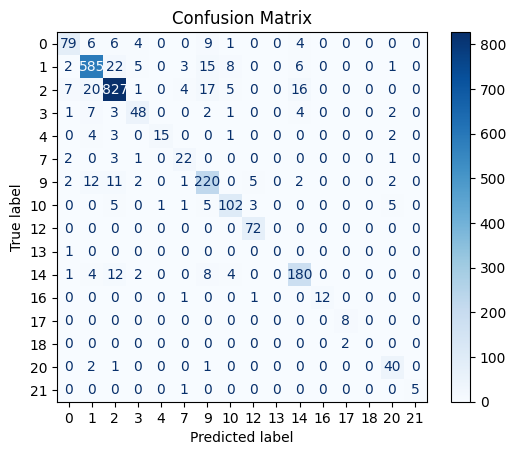

In [ ]:
cm = confusion_matrix(true_labels, predicted_classes, labels=unique_labels)  # Specify labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)  # Updated labels
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
test_results.label_ids

array([ 2,  3,  3, ...,  1, 12, 12])

In [ ]:
labels = label_encoder.classes_
x = np.arange(len(labels))  # Class indices

# precision = [test_results.metrics['test_micro_precision'], test_results.metrics['test_macro_precision'], test_results.metrics['test_weighted_precision']]
# recall = [test_results.metrics['test_micro_recall'], test_results.metrics['test_macro_recall'], test_results.metrics['test_weighted_recall']]
# f1 = [test_results.metrics['test_micro_f1'], test_results.metrics['test_macro_f1'], test_results.metrics['test_weighted_f1']]

precision = test_results.metrics['test_weighted_precision']
recall = test_results.metrics['test_weighted_recall']
f1 = test_results.metrics['test_weighted_f1']


In [ ]:
class_report = classification_report(true_labels, predicted_classes, target_names=unique_labels, output_dict=True)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
class_report_df = pd.DataFrame(class_report).transpose()

In [ ]:
print(class_report_df)

              precision    recall  f1-score      support
0              0.831579  0.724771  0.774510   109.000000
1              0.914062  0.904173  0.909091   647.000000
2              0.926092  0.921962  0.924022   897.000000
3              0.761905  0.705882  0.732824    68.000000
4              0.937500  0.600000  0.731707    25.000000
7              0.666667  0.758621  0.709677    29.000000
9              0.794224  0.856031  0.823970   257.000000
10             0.836066  0.836066  0.836066   122.000000
12             0.888889  1.000000  0.941176    72.000000
13             0.000000  0.000000  0.000000     1.000000
14             0.849057  0.853081  0.851064   211.000000
16             1.000000  0.857143  0.923077    14.000000
17             0.800000  1.000000  0.888889     8.000000
18             0.000000  0.000000  0.000000     2.000000
20             0.754717  0.909091  0.824742    44.000000
21             1.000000  0.833333  0.909091     6.000000
accuracy       0.881768  0.8817

In [ ]:
class_metrics = class_report_df.iloc[:-3, :]  # Excluding 'accuracy', 'macro avg', 'weighted avg'
precision = class_metrics['precision']
recall = class_metrics['recall']
f1 = class_metrics['f1-score']
classes = class_metrics.index

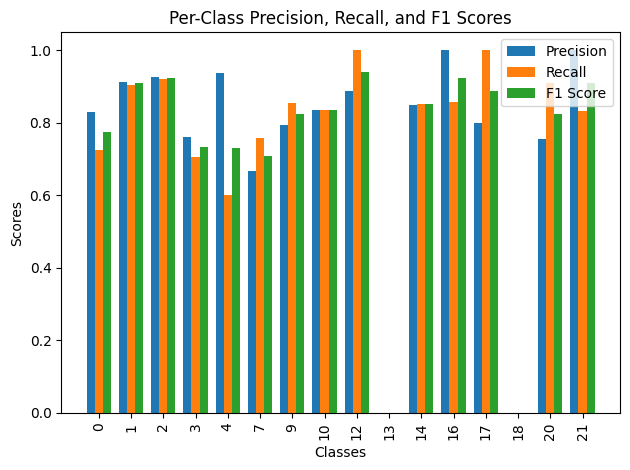

In [ ]:
x = np.arange(len(classes))  # Class indices
width = 0.25

plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1 Score')

plt.xlabel("Classes")
plt.ylabel("Scores")
plt.title("Per-Class Precision, Recall, and F1 Scores")
plt.xticks(x, classes, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

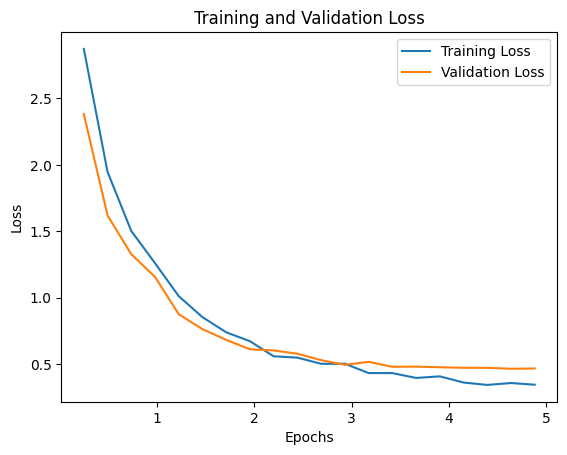

In [ ]:
training_history = trainer.state.log_history

# Plot training loss
epochs = [log["epoch"] for log in training_history if "loss" in log]
loss = [log["loss"] for log in training_history if "loss" in log]
eval_loss = [log["eval_loss"] for log in training_history if "eval_loss" in log]

plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, eval_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

### ROC

In [ ]:
from sklearn.preprocessing import label_binarize
from itertools import cycle

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


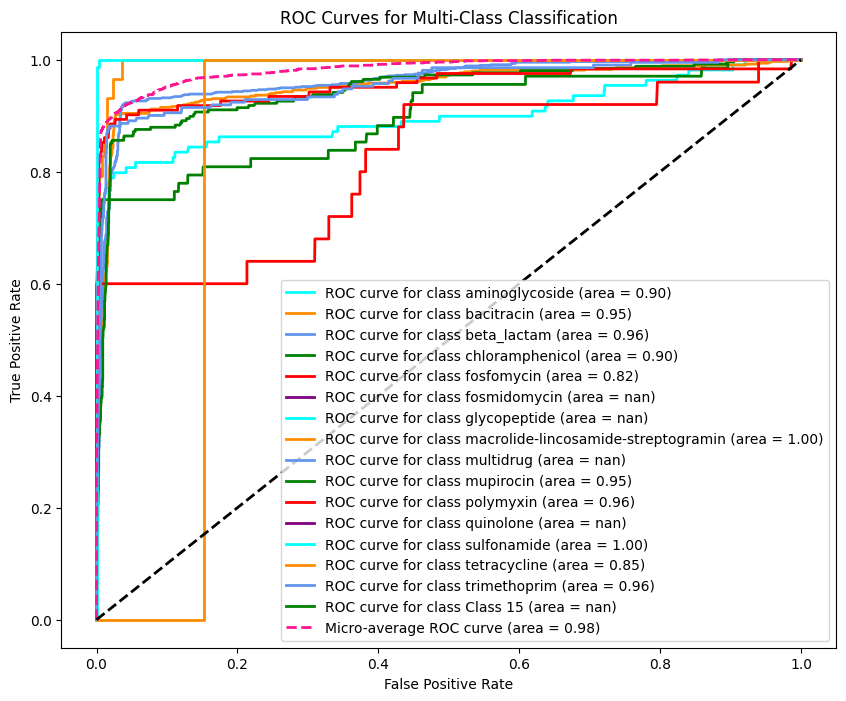

In [ ]:
# Number of classes
n_classes = len(unique_labels)

# Binarize the true labels
binarized_labels = label_binarize(true_labels, classes=range(n_classes))

# Predicted probabilities for each class (output from the model's softmax layer)
y_prob = test_results.predictions[:, :n_classes]    # shape: (n_samples, n_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(binarized_labels.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(["aqua", "darkorange", "cornflowerblue", "green", "red", "purple"])
for i, color in zip(range(n_classes), colors):
    # Check if i is within the bounds of labels
    label_name = labels[i] if i < len(labels) else f"Class {i}"
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve for class {label_name} (area = {roc_auc[i]:0.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average ROC curve (area = {roc_auc['micro']:0.2f})",
         color="deeppink", linestyle="--", linewidth=2)

# Plot diagonal line for reference
plt.plot([0, 1], [0, 1], "k--", lw=2)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multi-Class Classification")
plt.legend(loc="lower right")
plt.show()